# Time-Series Mortgage Default Modeling & Evaluation

This notebook implements predictive modeling for next-period mortgage default using:

- Lag-adjusted behavioral features
- Time-based validation
- Logistic Regression (interpretable baseline)
- XGBoost (non-linear benchmark)
- ROC-AUC & PR-AUC evaluation
- Feature importance comparison


In [5]:
# Import Necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix,
                             roc_auc_score,
                             average_precision_score)
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, cohen_kappa_score, brier_score_loss
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import umap

import xgboost as xgb

import warnings
import time
warnings.filterwarnings("ignore")

from multiprocessing import Pool
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from collections import Counter

In [7]:
transformed_df = pd.read_csv(
    r"C:\dwaraka\github projects\Risk Analytics\Freddie_mac_raw_data\transformed_final.csv"
)

# 🔥 CRITICAL STEP
transformed_df['Monthly Reporting Period'] = pd.to_datetime(
    transformed_df['Monthly Reporting Period']
)

df_model = transformed_df.copy()

df_model = df_model.sort_values('Monthly Reporting Period')

# Use last 20% of time as test
split_date = df_model['Monthly Reporting Period'].quantile(0.80)

train = df_model[df_model['Monthly Reporting Period'] <= split_date]
test = df_model[df_model['Monthly Reporting Period'] > split_date]

X_train = train.drop(['Loan Sequence Number','Monthly Reporting Period','label_target','target_0&1'], axis=1)
y_train = train['target_0&1']

X_test = test.drop(['Loan Sequence Number','Monthly Reporting Period','label_target','target_0&1'], axis=1)
y_test = test['target_0&1']

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (21882, 40)
Test shape: (5097, 40)


In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
log_model = LogisticRegression(class_weight='balanced', max_iter=500)
log_model.fit(X_train_scaled, y_train)

log_pred = log_model.predict(X_test_scaled)
log_proba = log_model.predict_proba(X_test_scaled)[:,1]

print("Logistic Results")
print(confusion_matrix(y_test, log_pred))
print(classification_report(y_test, log_pred))

print("ROC-AUC:", roc_auc_score(y_test, log_proba))
print("PR-AUC:", average_precision_score(y_test, log_proba))
print("F1:", f1_score(y_test, log_pred))


Logistic Results
[[3056 1664]
 [  20  357]]
              precision    recall  f1-score   support

           0       0.99      0.65      0.78      4720
           1       0.18      0.95      0.30       377

    accuracy                           0.67      5097
   macro avg       0.59      0.80      0.54      5097
weighted avg       0.93      0.67      0.75      5097

ROC-AUC: 0.842346468551904
PR-AUC: 0.22774473152394864
F1: 0.29774812343619683


In [10]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    max_depth=4,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:,1]

print("XGBoost Results")
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

print("ROC-AUC:", roc_auc_score(y_test, xgb_proba))
print("PR-AUC:", average_precision_score(y_test, xgb_proba))
print("F1:", f1_score(y_test, xgb_pred))


XGBoost Results
[[4382  338]
 [ 322   55]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4720
           1       0.14      0.15      0.14       377

    accuracy                           0.87      5097
   macro avg       0.54      0.54      0.54      5097
weighted avg       0.87      0.87      0.87      5097

ROC-AUC: 0.7954631794272355
PR-AUC: 0.1612494522530833
F1: 0.14285714285714285


In [11]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "XGBoost"],
    "ROC-AUC": [
        roc_auc_score(y_test, log_proba),
        roc_auc_score(y_test, xgb_proba)
    ],
    "PR-AUC": [
        average_precision_score(y_test, log_proba),
        average_precision_score(y_test, xgb_proba)
    ],
    "F1 Score": [
        f1_score(y_test, log_pred),
        f1_score(y_test, xgb_pred)
    ]
})

results


,Model,ROC-AUC,PR-AUC,F1 Score
0,Logistic Regression,0.842346,0.227745,0.297748
1,XGBoost,0.795463,0.161249,0.142857


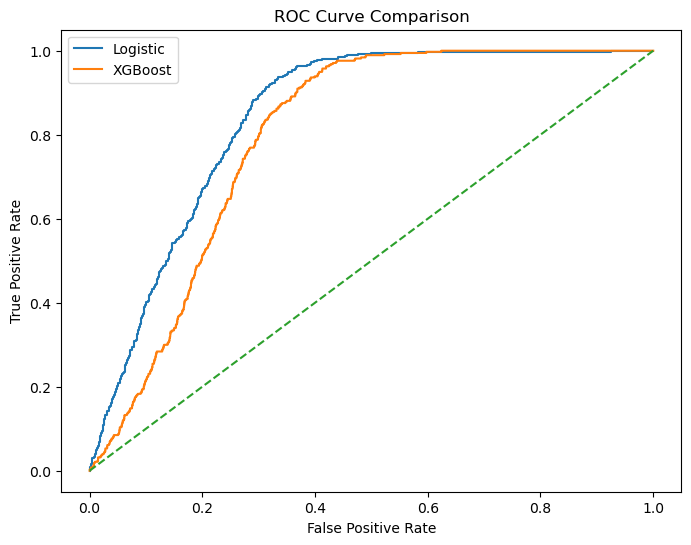

In [12]:
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label="Logistic")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, log_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
print("Best Threshold:", best_threshold)
print("Best F1:", f1_scores[best_idx])


Best Threshold: 0.9346098925775266
Best F1: 0.3219264892268694


In [14]:
log_pred_opt = (log_proba >= best_threshold).astype(int)

print(confusion_matrix(y_test, log_pred_opt))
print(classification_report(y_test, log_pred_opt))


[[3773  947]
 [ 123  254]]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      4720
           1       0.21      0.67      0.32       377

    accuracy                           0.79      5097
   macro avg       0.59      0.74      0.60      5097
weighted avg       0.91      0.79      0.83      5097



In [15]:
from scipy.stats import ks_2samp

ks_stat = ks_2samp(
    log_proba[y_test == 1],
    log_proba[y_test == 0]
)

print("KS Statistic:", ks_stat.statistic)


KS Statistic: 0.602653081868453
